# Euristica per la risoluzione del problema di  Pompei-Orienteering

## 1 Contesto del problema

Il problema dell'**Orienteering (OP)** consiste nel generare percorsi vincolati nel **tempo TMAX (o nella distanza DMAX)** attraverso un grafo, per un giocatore (nel nostro caso un turista), in modo tale che lo **score** ottenuto visitando i nodi venga massimizzato. Ciascun tour di un giocatore inizia in un nodo (**start point**) diverso dal nodo di terminazione (**end point**). 

Il problema dell'Orienteering (OP), introdotto da Golden nel 1987, presenta due varianti quella considerata nel seguente elaborato è quella **deterministica** del problema, in cui un giocatore sceglie l'insieme di nodi da visitare in maniera tale che l'ordine di visita non ecceda l'intervallo di tempo specificato TMAX (o la distanza massima DMAX). Questo è un problema molto generale che si trova in numerose applicazioni, compreso il problema della **pianificazione di un tour turistico**.

I metodi utilizzati per risolvere la versione deterministica del problema includono:
 - Particle swarm optimization;
 - Simulated annealing;
 - Genetic algorithm;
 - Pareto mimic algorithm;
 - Branch-and-cut-and-price algorithms.

Metodi risolutivi di questo problema molto più recenti sono i cosiddetti **Algoritmi simeuristici (Juan e Panadero nel 2017)** che combinano simulazione e metaeuristica per risolvere l'OP, ed in cui il **tuning dei parametri** avviene tramite le osservazioni dell'algoritmo in esecuzione.

### 1.1 Variante del problema - Stochastic Orienteering Problem

L'altra variante del problema di Orienteering è quella **stocastica (SOP)**, tale variante è un'estensione dell'OP in cui i tempi di viaggio tra i nodi o le ricompense dei nodi sono aleatori.

Nel caso di OP contano solo le ricompense raccolte entro un periodo di tempo limitato. Nel SOP l'**obiettivo principale non è solo quello di massimizzare la ricompensa totale, ma anche di ottenere una soluzione affidabile**. In cui per affidabilità, si intende che una soluzione è ritenuta inammissibile se uno qualsiasi dei tour non viene completato entro il limite di tempo specificato TMAX (o non rispetti la distanza massima DMAX).

Dunque, in questo approccio si valuta l'affidabilità come la probabilità che una soluzione possa essere completata senza errori. Questo lavoro considera uno SOP con ricompense dinamiche (SOPDR), in cui le ricompense associate ai nodi hanno una componente statica (score assegnato) e anche una componente dinamica. 
La componente dinamica tiene conto: 
 - dei bonus per i nodi visitati in anticipo in un percorso; 
 - delle penalità per i nodi visitati in ritardo in un percorso. 

Il processo attraverso il quale i valori dei bonus e i valori di penalità vengono generati è un processo sperimentale, in cui l'unica fonte di conoscenza è quella delle osservazioni in fase di simulazione. Ad esempio, si potrebbe immaginare il caso in cui si ottengano bonus per i nodi visitati come primo nodo in un percorso, mentre le penalità vengano applicate per i nodi visitati per ultimi nel percorso. I valori di bonus e penalità per i nodi si presume che seguano una distribuzione statistica sconosciuta. Quando si risolve lo SOPDR, la sfida consiste nell'apprendere i bonus e le penalità associati a ciascun nodo dalle simulazioni di soluzioni candidate, mentre, allo stesso tempo, si cerca di massimizzare la ricompensa totale e anche di assicurare che le soluzioni abbiano un buon livello di affidabilità in termini di TMAX (o DMAX).

In [1]:
import functools
import heapq
import collections


#-------------------------CLASSI DELL'ALGORITMO--------------------------
class Edge:
    def __init__(self, inode, jnode, cost):
        """
        Definisco una classe relativi agli archi del grafo.
        - inode: Il nodo di partenza.
        - jnode: Il nodo di terminazione.
        - cost: Distanza tra inode e jnode.
        """
        self.inode = inode
        self.jnode = jnode
        self.cost = cost
        self.savings = dict()

        
class Route:
    """
    Un'istanza di questa classe rappresenta un percorso dal nodo di 
    partenza al nodo di arrivo effettuato da un giocatore.
    """
    def __init__(self, source, depot, starting_node):
        """
        - source: Nodo di partenza del percorso.
        - depot: Nodo di arrivo del percorso.
        - starting_node: Primo nodo incluso nel percorso.

        - nodes: I nodi che formano il percorso.
        - score: Il punteggio totale del percorso.
        - cost: Il costo totale (distanza) del percorso.
        """
        self.source = source
        self.depot = depot
        self.nodes = collections.deque([starting_node])
        self.score = starting_node.score
        self.cost = starting_node.from_source + starting_node.to_depot

    def merge (self, other, edge, dists):
        """
        Questa funzione unisce due percorsi in un solo percorso.

        - other: Percorso alternativo da unire con il percorso attuale.
        - edge: Gli archi usati per unire i due percorsi.
        - dists: La matrice delle distanze tra i nodi.
        """
        # Ottengo il costo e i nodi dell'arco
        inode, jnode = edge.inode, edge.jnode
        edge_cost = dists[inode.id, jnode.id]
        # Aggiorna l'elenco dei nodi nel percorso
        self.nodes.extend(other.nodes)
        # inode non è più connesso al nodo di arrivo
        # e jnode non è più connesso al nodo di partenza
        inode.link_right = False
        jnode.link_left = False
        # Aggiorna il punteggio e il costo di questo percorso
        self.cost += edge_cost - inode.to_depot + (other.cost - jnode.from_source)
        self.score += other.score
        # Aggiorna il percorso a cui appartengono i nodi
        for node in other.nodes:
            node.route = self


class Node:
    def __init__(self, id, x, y, score, *, color='#FDDD71', issource=False, isdepot=False):
        """
        Definisco la classe dei nodi del grafo (ovvero i siti da visitare).
        - id: ID del nodo.
        - x: Longitudine del nodo.
        - y: Latitudine del nodo.
        - score: Lo score relativo alla visita di quel nodo.
        - issource: Una variabile booleana che dice se il nodo è il punto di partenza.
        - isdepot: Una variabile booleana che dice se il nodo è il punto di arrivo.
        - vehicles: Il numero di veicoli che partono da questo nodo (è 0 se il nodo non è la partenza).

                    *** Parametri usati da Mapper ***
        - assigned: Assume valore 1 se il nodo è assegnato ad un nodo sorgente e 0 altrimenti.
        - preferences: Utilizzato in caso di nodo di partenza per la ricerca greedy dei nodi da collegare.
        - nodes: Utilizzato nel caso del nodo di partenza per conservare i nodi ad esso assegnati.

                    *** Parametri usati da PJS (Panadero Juan Savings) ***
        - from_source: La lunghezza del percorso corrente dal nodo di partenza a questo nodo.
        - to_depot: La lunghezza del percorso corrente da questo nodo al nodo di arrivo.
        - route: Il percorso corrente corrispondente al nodo.
        - link_left: Assume valore 1 se il nodo è collegato al nodo di partenza, 0 altrimenti.
        - link_right: Assume valore 1 se il nodo è collegato al nodo di arrivo, 0 altrimenti.
        """
        self.id = id
        self.x = x
        self.y = y
        self.score = score
        self.issource = issource
        self.isdepot = isdepot

        # Mapper
        self.assigned = False
        self.preferences = collections.deque()
        self.nodes = collections.deque()

        # PJS
        self.from_source = 0
        self.to_depot = 0
        self.route = None
        self.link_left = False
        self.link_right = False
        
        
class Problem:
    """
    Un'istanza di questa classe rappresenta un problema di Orienteering.
    """

    def __init__(self, name, n_nodes, DMAX, sources, nodes, depot):
        """
        - name: Il nome del problema
        - n_nodes: Il numero di nodi.
        - DMAX: La distanza massima percorribile dai giocatori / budget di tempo per i percorsi.
        - sources: Il nodo di partenza.
        - nodes: I nodi da visitare.
        - depot: Il nodo di arrivo.

        - dists: La matrice delle distanze tra i nodi.
        - positions: Un dizionario delle posizioni dei nodi.
        - edges: Gli archi che collegano i nodi.
        """
        self.name = name
        self.n_nodes = n_nodes
        self.DMAX = DMAX
        self.sources = sources
        self.nodes = nodes
        self.depot = depot

        # Inizializzo l'elenco degli archi e le posizioni dei nodi
        edges = collections.deque()
        dists = np.zeros((n_nodes, n_nodes))
        # Calcolo la matrice delle distanze e istanzio gli archi
        # e definisco i colori e le posizioni dei nodi
        source_id = 0
        for node1, node2 in itertools.permutations(itertools.chain(sources, nodes, (depot,)), 2):
            # Calcolo il costo dell'arco con la funzione euclidean()
            id1, id2 = node1.id, node2.id
            cost = euclidean(node1, node2)
            # Compilo la matrice orientata delle distanze
            dists[id1, id2] = cost
            # Crea l'arco
            if not node1.isdepot and not node2.issource:
                edges.append(Edge(node1, node2, cost))

        self.dists = dists
        self.edges = edges


    def iternodes (self):
        """
        Un metodo per iterare su tutti i nodi del problema (es. partenza, nodi da visitare, arrivo)
        """
        return itertools.chain(self.sources, self.nodes, (self.depot,))

In [2]:
import random
import math

#--------------------------------ITERATORI------------------------------------------
def greedy (preferences):
    """
    Questa funzione effettua una ricerca greedy dei nodi da collegare alla sorgente
    ordinandoli dal migliore al peggiore, e non appena incontra un nodo che non è 
    stato ancora assegnato, lo restituisce.

    - preferences: La lista dei nodi da collegare ordinati dal migliore al peggiore.
    """
    for _, node in preferences:
        if not node.assigned:
            yield node


def BRA (preferences, beta=0.3):
    """
    Questo metodo (Biased Randomised Approach) effettua una selezione casuale e 
    parziale sull'elenco dei nodi. La selezione si basa su una funzione quasi 
    geometrica, di questo tipo:
                          f(x) = (1 - beta) ^ x
    e quindi dà la priorità ai primi elementi dell'elenco.

    - preferences: La lista dei nodi da collegare ordinati dal migliore al peggiore.
    - beta: Il parametro della distribuzione quasi geometrica.
    
    Valore di ritorno: L'elemento selezionato ad ogni iterazione.
    """
    L = len(preferences)
    options = list(preferences)
    for _ in range(L):
        idx = int(math.log(random.random(), 1.0 - beta)) % len(options)
        _, node = options.pop(idx)
        if not node.assigned:
            yield node

In [3]:
import numpy as np
import itertools
import operator


#--------------------------MAPPATURA--------------------------
def _reset_assignment (node):
    """
    Metodo utilizzato per reimpostare l'affiliazione di un nodo a una sorgente.
    """
    node.assigned = False
    return node


def mapper (problem, iterator):
    """
    Questa funzione ricostruisce il percorso dal nodo di partenza al nodo di arrivo.

    - problem: Istanza dell'Orienteering Problem da risolvere.
    - iterator: Iteratore greedy usato per prelevare i nodi dall'elenco di visita.
    
    Valore di ritorno: Un percorso in 2-dimensioni, dove il generico elemento (i, j) è 
    1 se il nodo j è assegnato al nodo sorgente i, 0 altrimenti.
    """
    # Estrae le caratteristiche del problema
    dists = problem.dists
    sources, nodes, depot = problem.sources, problem.nodes, problem.depot
    n_sources, n_nodes = len(problem.sources), len(problem.nodes)

    # Reimposta l'origine a cui appartengono i nodi
    nodes = tuple(map(_reset_assignment, nodes))

    # Calcola le distanze (euclidee) assolute tra due nodi
    abs_dists = np.array([[dists[s.id, n.id] for n in nodes] for s in sources]).astype("float32")

    # Calcola le distanze marginali
    for i, source in enumerate(sources):
        marginal_dists = abs_dists[i,:] - np.concatenate((abs_dists[:i,:], abs_dists[i:,:],), axis=0).min(axis=0)
        source.preferences = iterator(sorted(zip(marginal_dists, nodes), key=operator.itemgetter(0)))
        source.nodes = collections.deque()

    # Assegna nodi alle origini
    # Inizializza il numero di nodi già assegnati e la matrice di mappatura
    n_assigned = 0
    mapping = np.zeros((n_sources, n_sources + n_nodes))
    _null_element = object()
    # Finchè ci sono nodi non assegnati
    for source in itertools.islice(itertools.cycle(sources), n_nodes):
        # Considero la lista dei nodi relativi al nodo sorgente attualmente considerato
        preferences = source.preferences
        # Prelevo un nodo
        picked_node = next(preferences, _null_element)
        # Se non ci sono più nodi esco
        if picked_node is _null_element:
            break
        # Assegno il nodo alla sorgente
        source.nodes.append(picked_node)
        picked_node.assigned = True
        mapping[source.id, picked_node.id] = 1
        n_assigned += 1

        # Se tutti i nodi sono stati assegnati esco dal ciclo
        if n_assigned == n_nodes:
            break

    # Ritorno il percorso
    return mapping

### 1.2 Approccio euristico di apprendimento per il Deterministic Orienteering Problem

Per risolvere il problema di Orienteering con un approccio euristico si può pensare di usare un approccio di tipo **Biased Randomisation Approach (BRA)**. In generale, questa euristica di apprendimento integra la metaeuristica con gli algoritmi di **Machine Learning** allo scopo di risolvere problemi di ottimizzazione combinatoria come dei problemi di apprendimento. 
L'algoritmo di **Biased Randomisation Heuristic** svolge il ruolo dell'**algoritmo di ottimizzazione**, mentre la **simulazione** si occupa di effettuare il **tuning dei parametri $\alpha$ e $\beta$**, attraverso un semplice meccanismo di apprendimento dalle osservazioni. Combinando la simulazione con i metodi euristici, l'algoritmo simheuristico risultante mira a estendere le capacità dei classici algoritmi di randomizzazione parziale nella modellazione e nella gestione delle dimensioni di un problema.
Le ragioni di tale miglioramento sono le seguenti:

 - tramite la **parametrizzazione dell'approccio randomizzato** si possono costruire un'**ampia gamma di soluzioni** con caratteristiche diverse fra di loro e quindi, avere una **maggior probabilità di ottenere una soluzione subottima**;
 - tramite la **procedura greedy** di generazione della soluzione di base si ha la capacità di **ridurre le dimensioni dell'intorno della soluzione da ispezionare**, infatti, si considererà solo l'insieme delle soluzioni non dominate come soluzioni candidate.
 
### 1.3 Algoritmo di Biased Randomisation con il calcolo dei Panadero-Juan Savings

Gli algoritmi di **Biased Randomisation** si basano sull'introduzione della casualità in un algoritmo greedy. Gli algoritmi costruttivi si basano sulla generazione di soluzioni con un approccio greedy e selezionando in sequenza gli elementi da includere in una soluzione. In questo caso, le soluzioni candidate sono ordinate in un elenco discendente del valore della funzione obiettivo relativa a ciascuna mossa intraprendibile. Probabilità decrescente di selezione sono assegnati agli elementi in questo elenco, questa distribuzione di probabilità asimmetrica per la selezione degli elementi nella soluzione introduce in un certo senso la casualità in un algoritmo greedy che preserva la logica alla sua base. Questo approccio di generazione di una vasta gamma di soluzioni alternative consentono di migliorare la soluzione generata dalla sola procedura greedy di base. Tali tecniche hanno riscosso un grande successo migliorando le prestazioni dell'euristica classica, sia nelle applicazioni di schedulazione che in quelle di routing dei veicoli.
La base costruttiva dell'euristica utilizzata in questo elaborato è composta dalle seguenti fasi:

 1. In primo luogo, viene generata una **soluzione fittizia iniziale**. Questa soluzione fittizia iniziale è composta da tutti i percorsi che partono dal nodo di partenza passano per un nodo intermedio per poi andare al nodo di arrivo.
 2. Viene selezionata una coppia di percorsi per l'unione. Un'operazione di unione si basa sul tentativo di aggiungere un percorso alla fine di un altro, ovvero si cerca di unire il nodo di arrivo di un percorso con il nodo di partenza dell'altro percorso. Le possibili operazioni di unione sono ordinate in base a una somma ponderata del saving sul costo del viaggio, ovvero la distanza del viaggio ed il punteggio associato ai nodi alle due estremità dell'arco di unione. Il **saving, calcolato secondo il metodo di Panadero-Juan** associato all'arco (i,j) è il seguente: $\newline$  \begin{equation} saving_{ij} = \alpha (d_{in} + d_{0j} − d_{ij}) + (1−\alpha) (score_i + score_j) \end{equation} $\newline$ dove $d_{ij}$ rappresenta la distanza del nodo i dal nodo j. L'equazione per il calcolo del saving fornisce un peso pari ad $\alpha$ al saving sul costo relativo all'inserimento dell'arco (i,j) e un peso di $(1−\alpha)$ per gli score relaviti ai nodi appena uniti per formare il percorso totale. Ciò riflette gli obiettivi principali nella risoluzione di un OP, ovvero quelli di generare efficienza (rispettare la distanza massima DMAX) ed allo stesso tempo massimizzare il punteggio totale ottentuto. Una distribuzione di probabilità asimmetrica viene applicata all'elenco ordinato delle operazioni di unione, introducendo così la **"biased randomisation"** nell'algoritmo greedy di base. In particolare, si fa uso di una distribuzione geometrica, la cui equazione è data da: $\newline$ \begin{equation} randI = Mod (\lfloor \frac{log(uniRand(0,1))}{log(1−\beta)} \rfloor , \lvert C \rvert) \end{equation} $\newline$ il valore restituito da questa distribuzione è utilizzato per selezionare casualmente un indice (randI) dall'elenco delle soluzioni candidate, dove $\lvert C \rvert$ è la lunghezza della lista delle soluzioni candidate, uniRand è un input casuale uniforme tra 0 e 1 e $\beta$ è il parametro che controlla il livello di greedness e casualità in un algoritmo randomizzato. Ogni volta che $\beta = 1$, abbiamo che la scelta è completamente greedy. Al contrario, ogni volta che $\beta = 0$, otteniamo un comportamento totalmente casuale. Quando $0 \lt \beta \lt 1$, otteniamo un comportamento misto.
 3. Si ripete il passaggio 2., finché non sono più possibili unioni tra due percorsi.
 4. Tra i percorsi generati seguendo i passaggi 1. – 3., si seleziona il percorso che massimizza il punteggio totale.

Selezionando $0 \lt \beta \lt 1$ e ripetendo i passaggi 1. – 4. per un numero specificato di iterazioni o per un periodo di tempo, l'algoritmo di biased randomisation può generare **soluzioni di buona qualità**, che raggiungono un punteggio totale che si avvicina a quello ottimo. 

In [4]:
#----------------------------EURISTICA--------------------------------
def _bra (edges, beta):
    """
    Funzione che seleziona gli archi secondo un approccio di tipo Biased randomised.

    - edges: Lista degli archi.
    - beta: Il parametro della distribuzione quasi geometrica.
    
    Valore di ritorno: L'arco selezionato.
    """
    L = len(edges)
    options = list(edges)
    for _ in range(L):
        idx = int(math.log(random.random(), 1.0 - beta)) % len(options)
        yield options.pop(idx)


def PJS (problem, source, nodes, depot, beta):
    """
    In questa funzione è implementato l'algoritmo euristico di Panadero Juan Savings.
    Viene generalmente utilizzato per risolvere un problema di orienteering.

    - problem: L'istanza del problema da risolvere.
    - source: Il nodo di partenza per il quale verrà utilizzato il PJS.
    - nodes: I nodi da visitare.
    - depot: Il nodo di arrivo.
    - beta: Il parametro del biased randomisation (N.B. questo valore è vicino ad 1 per avere un comportamento greedy)

    Valore di ritorno: Il percorso che farà il giocatore a partire dal nodo di partenza fino a quello di arrivo.
    """
    # Sposto i valori utili nelle variabili locali
    dists, DMAX = problem.dists, problem.DMAX
    source_id, depot_id = source.id, depot.id

    # Filtro gli archi mantenendo solo quelli che interessano a questo sottoinsieme di nodi e li ordino
    sorted_edges = sorted([e for e in problem.edges if e.inode in nodes and e.jnode in nodes], key=lambda edge: edge.savings[source_id], reverse=True)
    # Costruisco una soluzione fittizia in cui un giocatore parte dal nodo di partenza e visita
    # un singolo nodo, per poi andare al nodo di arrivo.
    routes = collections.deque()
    for node in nodes:
        # Calcola le distanze dal nodo al nodo di arrivo
        # e dal nodo di partenza al nodo e le salvo.
        node.from_source = dists[source_id, node.id]
        node.to_depot = dists[node.id, depot_id]
        # Verifico se il nodo può essere visitato secondo il DMAX.
        if node.from_source + node.to_depot > DMAX:
            node.route = None
            continue
        # Alla fine costruisco un nuovo percorso che va dal
        # nodo di partenza al nodo e dal nodo al nodo di arrivo.
        route = Route(source, depot, node)
        node.route = route
        node.link_left = True
        node.link_right = True
        routes.append(route)

    # Unisco i percorsi dando priorità agli archi con il saving maggiore
    for edge in _bra(sorted_edges, beta):
        inode, jnode = edge.inode, edge.jnode
        iroute, jroute = inode.route, jnode.route
        # Se l'arco già connette i nodi nel percorso attuale
        # considero l'arco successivo
        if iroute is None or jroute is None or iroute == jroute:
            continue
        # Se inode è l'ultimo nodo del suo percorso e jnode è il primo del suo
        # percorso, l'unione dei due percorsi è possibile.
        if inode.link_right and jnode.link_left:
            # Confronta la lunghezza della nuova rotta con DMAX
            if iroute.cost - inode.to_depot + jroute.cost - jnode.from_source + edge.cost <= DMAX:
                # Unisce i due percorsi
                iroute.merge(jroute, edge, dists)
                # Rimuovere il percorso presente in iroute
                routes.remove(jroute)
        # Se ho trovato un percorso esco dal ciclo
        if len(routes) == 1:
            break

    # Restituisco il percorso trovato
    return sorted(routes, key=operator.attrgetter("score"), reverse=True)[:1]


@functools.lru_cache(maxsize=None)
def PJS_cache (problem, source, nodes, depot, alpha):
    """
    Implementazione memorizzata nella cache del PJS. 
    Usata per analizzare il comportamento euristico e deterministico dell'algoritmo
    senza il bisogno di esplorare diverse soluzioni.

    - alpha: Il valore alfa utilizzato per calcolare i savings sugli archi 
    (utilizzato solo per la memorizzazione nella cache)

    Valore di ritorno: Il percorso che farà il giocatore a partire dal nodo di partenza fino a quello di arrivo.
    """
    return PJS(problem, source, nodes, depot, beta=0.9999) #da provare a cambiare questo beta


def multistartPJS (problem, source, nodes, depot, alpha, maxiter, betarange):
    """
    Questo metodo è un'esecuzione multi-start del PJS. 
    Ad ogni iterazione, viene generata una nuova soluzione utilizzando un parametro beta
    diverso nella selezione degli archi per il processo di unione.

    - maxiter: Il numero massimo di iterazioni.
    - betarange: L'intervallo in cui il beta viene generato casualmente ad ogni iterazione.
    
    Valore di ritorno: La migliore soluzione trovata come insieme di percorsi, e il rispettivo punteggio.
    """
    # Genera la soluzione greedy di partenza
    bestroutes = PJS_cache(problem, source, nodes, depot, alpha)
    bestscore = sum(r.score for r in bestroutes)

    # Salva il range in cui varia il beta
    betamin, betamax = betarange

    for _ in range(maxiter):

        # Genera una nuova soluzione
        routes = PJS(problem, source, nodes, depot, beta=random.uniform(betamin, betamax))
        score = sum(r.score for r in routes)

        # Eventualmente aggiorno il percorso migliore
        if score > bestscore:
            bestroutes, bestscore = routes, score

    # Restituisco la migliore soluzione trovata finora
    return bestroutes, bestscore

### 1.4 Diagramma di flusso dell'euristica

Le operazioni **greedy** di base per la generazione delle soluzioni fittizie iniziali sono le seguenti:

$\newline$
<div>
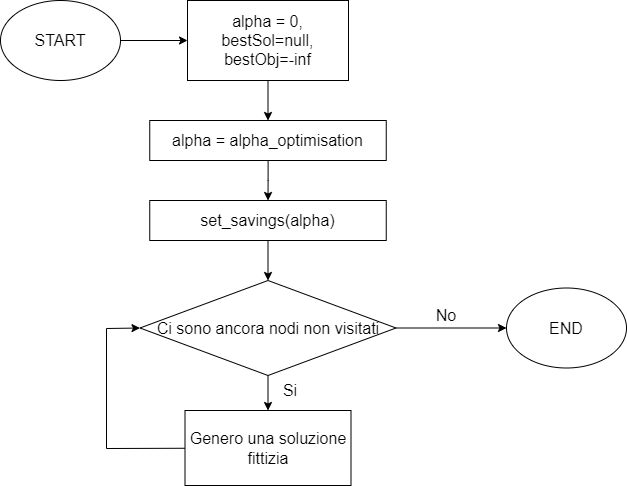
</div>
$\newline$

Nel seguente diagramma viene mostrato il flowchart delle operazioni effettuato dall'**euristica multistart** per calcolare il percorso con punteggio totale migliore:

$\newline$
<div>
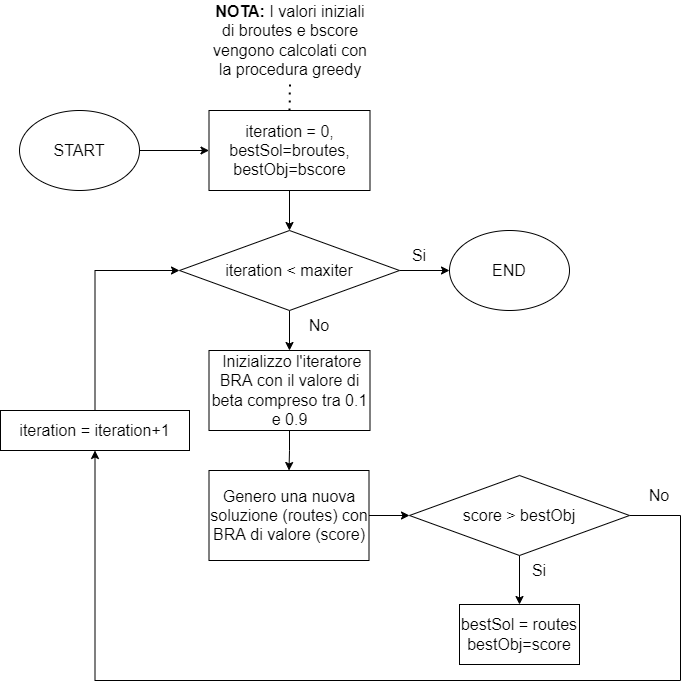
</div>
$\newline$

In [5]:
#-------------------------------RISOLUTORE--------------------------------
def set_savings (problem, alpha=0.3):
    """
    Questo metodo calcola il saving degli archi in base all'alfa dato.

    NOTA: gli archi vengono modificati sul posto.

    - problem: L'istanza del problema da risolvere.
    - alpha: Il parametro alfa del PJS.
    
    Valore di ritorno: L'istanza del problema modificata sul posto.
    """
    dists, depot = problem.dists, problem.depot
    for edge in problem.edges:
        cost, inode, jnode = edge.cost, edge.inode, edge.jnode
        score = inode.score + jnode.score
        edge.savings = {
            source.id : alpha*(dists[inode.id, depot.id] + dists[source.id, jnode.id] - cost) + (1.0-alpha)*score
        for source in problem.sources}
    return problem


def alpha_optimisation (problem, alpha_range=np.arange(0.0, 1.1, 0.1)):
    """
    Questo metodo viene utilizzato per ottimizzare il parametro alfa.
    Il parametro alfa viene utilizzato nel calcolo dei savings sugli archi:

        saving = alfa*distanza_saving + (1-alfa)*punteggio

    Più alto è alfa, maggiore è l'importanza del punteggio,
    più basso è alfa, maggiore è l'importanza della distanza di saving.

    In pratica eseguiamo 10 esecuzioni deterministiche dell'algoritmo
    (cioè, Mapper e poi PJS) per 10 diversi livelli di alfa.
    Il valore dell'alfa che fornisce la migliore soluzione deterministica
    viene salvato come il migliore alfa.

    NOTA: Questo metodo modifica anche il saving degli archi.

    - problem: L'istanza del problema da risolvere.
    - alpha_range: Il range di alfa da testare.
    
    Valore di ritorno: Il miglior valore ottenuto per l'alfa.
    """
    # Sposto i valori utili nelle variabili locali
    dists, depot, sources, nodes = problem.dists, problem.depot, problem.sources, problem.nodes
    
    # Eseguo una volta il mapper deterministico
    mapping = mapper(problem, iterator=greedy)

    # Inizializzo il migliore alfa a zero
    best_alpha, best_score = 0.0, float("-inf")

    # Proviamo diversi valori del parametro alfa e manteniamo il migliore
    for alphatest in alpha_range:
        # Provo un nuovo valore di alfa
        alphatest = round(alphatest, 1)
        # Calcolo i risparmi sugli archi in base al nuovo valore di alfa
        set_savings(problem, alphatest)
        # Eseguo una versione deterministica dell'algoritmo PJS per ciascuna sorgente.
        routes = []
        for source in problem.sources:
            partial_routes = PJS_cache(problem, source, tuple(source.nodes), depot, alphatest)
            routes.extend(partial_routes)
        # Punteggio totale ottenuto (vale a dire, qualità della soluzione)
        total_score = sum(r.score for r in routes)
        # Eventualmente aggiorno il valore dell'alfa
        if total_score > best_score:
            best_alpha, best_score = alphatest, total_score
    # Imposta il saving degli archi utilizzando l'alfa migliore trovato
    set_savings(problem, best_alpha)
    # Restituisce il miglior alfa ottenuto
    return best_alpha


def heuristic (problem, iterator, alpha):
    """
    Questa è l'esecuzione principale del risolutore.
    Può essere deterministico o stocastico a seconda dell'iteratore
    passato come argomento. (ad esempio, greedy e Biased Randomised Approach)

    - problem: L'istanza del problema da risolvere.
    - iterator: L'iteratore da passare al mapper.
    - alpha: Il valore alfa utilizzato per calcolare i savings sugli archi (utilizzato solo per la memorizzazione nella cache)
    
    Valore di ritorno: La soluzione come insieme di percorsi, il loro punteggio totale, e la matrice di mappatura.
    """
    # Mapper
    mapping = mapper(problem, iterator)
    # PJS per calcolare i percorsi
    routes = []
    for source in problem.sources:
        r = PJS_cache(problem, source, tuple(source.nodes), problem.depot, alpha)
        routes.extend(r)
    # Calcolo il punteggio totale
    score = sum(r.score for r in routes)
    # Restituisco la mappatura, i percorsi e il punteggio
    return score, mapping, tuple(routes)


def multistart (problem, alpha, maxiter=1000, betarange=(0.1, 0.3)):
    """
    Questa è l'esecuzione multistart dell'algoritmo PJS.
    Ad ogni iterazione viene generata una nuova soluzione introducendo
    lievi modifiche attraverso un approccio biased randomised.
    La nuova soluzione generata viene confrontata con la migliore e
    eventualmente sostituita (se il punteggio ottenuto è maggiore).

    - problem: L'istanza del problema da risolvere.
    - alpha: Il valore alfa utilizzato per calcolare i savings sugli archi (utilizzato solo per la memorizzazione nella cache)
    - maxiter: Il numero massimo di iterazioni e diverse mappature testate.
    - betarange: L'intervallo del parametro beta da utilizzare nel biased randomisation.

    Valore di ritorno: La migliore soluzione trovata finora con la rispettiva mappatura e punteggio.
    """
    # Verifico i valori forniti per il parametro beta
    if betarange[0] > betarange[1]:
        raise Exception("Min beta should be higher than max beta.")

    # Salva l'intervallo di beta
    minbeta, maxbeta = betarange

    # Inizializzo la soluzione di partenza come quella greedy
    bscore, bmapping, broutes = heuristic(problem, iterator=greedy, alpha=alpha)

    # Ricerca locale ripetuta
    for i in range(maxiter):

        # Inizializzo l'iteratore biased randomised
        _bra = functools.partial(BRA, beta=random.uniform(minbeta, maxbeta))

        # Genero una nuova soluzione
        score, mapping, routes = heuristic(problem, iterator=_bra, alpha=alpha)

        # Eventualmente aggiorno il migliore
        if score > bscore:
            bscore, bmapping, broutes = score, mapping, routes

    # Restituisco la migliore soluzione trovata finora
    return bscore, bmapping, broutes

In [6]:
import os
import networkx as nx


#-----------------------FUNZIONI DI UTILITA'---------------------------
def euclidean (inode, jnode):
    """
    Questo metodo calcola la distanza euclidea tra due nodi.

    - inode: Primo nodo.
    - jnode: Secondo nodo.
    """
    return math.sqrt((inode.x - jnode.x)**2 + (inode.y - jnode.y)**2)


def read_problem (path,filename, n_nodes, DMAX):
    """
    Questo metodo viene utilizzato per leggere un problema di Orienteering da un file .txt 
    e restituisce un'istanza di problema standard.

    - path: Il percorso in cui si trova il file.
    - filename: Il nome del file da leggere.
    - n_nodes: Il numero di nodi del problema
    - DMAX: Il valore di DMAX del problema
    
    Valore di ritorno: L'istanza del problema.
    """    
    with open(path + filename + '.txt', 'r') as file:
        # Initialise nodes lists
        sources, nodes, depot = [], [], None
        # Read nodes characteristics
        if (filename == "Scavi_Archeologici_Pompei_Anfiteatro_Misteri" or 
            filename == "Scavi_Archeologici_Pompei_Marina_Misteri" or
            filename == "Scavi_Archeologici_Pompei_Marina_Anfiteatro"):
            for i, line in enumerate(file):
                node_info = line.split(',')
                if i == 0:
                    # Add a source node
                    sources.append(Node(i, float(node_info[1]), float(node_info[2]), int(node_info[3]),
                                  issource=True))
                elif i == n_nodes - 1:
                    # Add the depot
                    depot = Node(i, float(node_info[1]), float(node_info[2]), int(node_info[3]), isdepot=True)
                else:
                    # Add a node to visit
                    nodes.append(Node(i, float(node_info[1]), float(node_info[2]), int(node_info[3])))
        else:
            for i, line in enumerate(file):
                node_info = line.split(',')
                if i == 0:
                    # Add a source node
                    sources.append(Node(i, float(node_info[0]), float(node_info[1]), int(node_info[2]),
                                  issource=True))
                elif i == n_nodes - 1:
                    # Add the depot
                    depot = Node(i, float(node_info[0]), float(node_info[1]), int(node_info[2]), isdepot=True)
                else:
                    # Add a node to visit
                    nodes.append(Node(i, float(node_info[0]), float(node_info[1]), int(node_info[2])))

        # Instantiate and return the problem
        return Problem(filename, n_nodes, DMAX, tuple(sources), tuple(nodes), depot)

In [7]:
import time


#---------------------------MAIN------------------------------
namefile = 'Scavi_Archeologici_Pompei_Marina_Misteri'
path = './IstanzeBenchmark/'

with open(path + namefile + '.txt', 'r') as file:
        # Read problem parameters
        n_nodes = len(file.readlines())
        DMAX = 0.02

if (namefile == "Scavi_Archeologici_Pompei_Anfiteatro_Misteri" or 
    namefile == "Scavi_Archeologici_Pompei_Marina_Misteri" or
    namefile == "Scavi_Archeologici_Pompei_Marina_Anfiteatro"):
    zoom = 16
else:
    zoom=4

problem = read_problem(path,namefile, n_nodes, DMAX)

alpha = alpha_optimisation(problem)

set_savings(problem, alpha=alpha)


print("alpha = " + str(alpha))


_start_h = time.time()

score_h, mapping_h, routes_h = heuristic(problem, greedy, alpha)

time_exec_h = round(time.time() - _start_h,3)

print("Heuristic --> Tempo: " + str(time_exec_h) + " Punteggio: " + str(score_h))


_start_m = time.time()

score_m, mapping_m, routes_m = multistart(problem, alpha, maxiter=1000, betarange=(0.1, 0.3))

time_exec_m = round(time.time() - _start_m,3)

print("Multistart --> Tempo: " + str(time_exec_m) + " Punteggio: " + str(score_m))


alpha = 0.1
Heuristic --> Tempo: 0.0 Punteggio: 53
Multistart --> Tempo: 4.283 Punteggio: 53


In [8]:
pos={}
for node in problem.iternodes():
        # Prelevo le coordinate dei nodi
        pos[node.id] = (node.x, node.y)
        
# Salvo il percorso
edges = []
for r in routes_h:
    # NOTA: i nodi del percorso dovrebbero essere sempre nell'ordine in cui
    # sono memorizzati all'interno del deque.
    nodes = tuple(r.nodes)
    edges.append((r.source.id, nodes[0].id))
    for n1, n2 in zip(nodes[:-1], nodes[1:]):
        edges.append((n1.id, n2.id))
    edges.append((nodes[-1].id, r.depot.id))
        
sortedpos=dict(edges)
mytour = []
distanza = 0
for i in sortedpos:
    distanza += problem.dists[i][sortedpos[i]]
    mytour.append([pos[i][0],pos[i][1]])
    
mytour.append([pos[problem.n_nodes-1][0],pos[problem.n_nodes-1][1]])

print('Distanza percorsa in km: ' + str(distanza))

Distanza percorsa in km: 0.019969975821347626


In [9]:
media_lat=0
media_long=0

for node in range(len(mytour)):
    media_lat = media_lat + float(mytour[node][0])
    media_long = media_long + float(mytour[node][1])
    
lat=media_lat/len(mytour)
long=media_long/len(mytour)

In [10]:
# Stampa del tour degli scavi di Pompei in linea d'aria 
import folium
map = folium.Map(location=[long,lat], zoom_start = zoom)
for i in range(len(mytour)):
    folium.Marker(location = (mytour[i][1],mytour[i][0]), tooltip = i, 
                  icon=folium.Icon(color='darkred')).add_to(map)

points = []
for i in range(len(mytour)):
    points.append((mytour[i][1],mytour[i][0]))

folium.PolyLine(points, color='darkred').add_to(map)

map

In [11]:
#Stampa del percorso per vie REALI 
#(ovviamente la distanza in km sarà leggermente diversa da quella in linea d'aria)
if (namefile == "Scavi_Archeologici_Pompei_Anfiteatro_Misteri" or 
    namefile == "Scavi_Archeologici_Pompei_Marina_Misteri" or
    namefile == "Scavi_Archeologici_Pompei_Marina_Anfiteatro"):
    import openrouteservice as ors
    import folium
    import folium.plugins as plugins

    # API Key di Open Route Service
    ors_key = '5b3ce3597851110001cf6248435cfcfbcf0c42858fde19dccf6f9c0f'

    # Richiesta dei servizi tramite API Key di ORS
    # Apro un Client per effettuare le richieste al Server di ORS
    client = ors.Client(key=ors_key)

    # Traccio il percorso
    route = client.directions(coordinates=mytour,
                              profile='foot-walking',
                              format='geojson')

    #Istanzio la mappa del problema
    map = folium.Map(location=[long,lat], zoom_start = 16)

    for i in range(len(sortedpos)+1):
        if i == 0: #start point 
            folium.Marker(location = (mytour[i][1],mytour[i][0]), tooltip = i, 
                          icon=plugins.BeautifyIcon(icon="arrow-down", icon_shape="marker",
                                                    number=i,
                                                    border_color= '#b22222',
                                                    background_color='#b22222')).add_to(map)
        elif i == len(sortedpos): #end point
            folium.Marker(location = (mytour[i][1],mytour[i][0]), tooltip = i, 
                          icon=plugins.BeautifyIcon(icon="arrow-down", icon_shape="marker",
                                                    number=i,
                                                    border_color= '#ffd700',
                                                    background_color='#ffd700')).add_to(map)
        else:
            folium.Marker(location = (mytour[i][1],mytour[i][0]), tooltip = i, 
                          icon=plugins.BeautifyIcon(icon="arrow-down", icon_shape="marker",
                                                    number=i,
                                                    border_color= '#b22222',
                                                    background_color='#ffffff')).add_to(map)

    # Aggiungo il GeoJson alla mappa
    folium.GeoJson(route, name=('Itinerario Scavi di Pompei con ' + str(DMAX) + ' ore'), 
                   style_function=lambda feature: {'color': 'darkred'}).add_to(map)

    # Aggiungo il livello del percorso alla mappa
    folium.LayerControl().add_to(map)

    print('Distanza percorsa in km: ' + str((route['features'][0]['properties']['summary']['distance'])/1000))

map

Distanza percorsa in km: 3.1586999999999996


In [12]:
import csv

colonne = ['Istanza','DMAX','Metodo','N.POI','Lunghezza percorso (km)','Valore di soddisfazione (TOTALE)','Tempo di esecuzione (s)']
with open('./Confronti.csv', mode='a', newline='') as csv_file:
    
    writer = csv.DictWriter(csv_file, fieldnames=colonne)

    writer.writerow({'Istanza': namefile,'DMAX': problem.DMAX,'Metodo': 'Heuristic','N.POI': len(sortedpos)+1,'Lunghezza percorso (km)': distanza,'Valore di soddisfazione (TOTALE)': score_h, 'Tempo di esecuzione (s)': time_exec_h})
    writer.writerow({'Istanza': namefile,'DMAX': problem.DMAX,'Metodo': 'Multistart','N.POI': len(sortedpos)+1,'Lunghezza percorso (km)': distanza,'Valore di soddisfazione (TOTALE)': score_m, 'Tempo di esecuzione (s)': time_exec_m})